#  Quantization aware (QKeras) My GraphConv Neural Network for Jet tagging using jet constituents from HLS data using CONV1D layers on fully conected graphs

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

    
# To disable GPU use
tf.config.set_visible_devices([], 'GPU')


TensorFlow 2.8.0
Number of available GPUs : 1


## Load train and test JetID datasets as numpy arrays 

In [3]:
import numpy as np
import h5py
import os

#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32
norm = 'standard'

X_train_val = np.load("../../data/X_train_val_nconst_{}_norm_{}.npy".format(nconstit,norm))
X_test = np.load("../../data/X_test_nconst_{}_norm_{}.npy".format(nconstit,norm))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}_norm_{}.npy".format(nconstit,norm))
Y_test = np.load("../../data/Y_test_nconst_{}_norm_{}.npy".format(nconstit,norm))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]

Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)


# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



## Define a GraphConv NN by applying a convolutional layer (Conv1D) over each node of a fully connected Graph. Weights of  convolutional filter ( kernel ) are shared across the nodes by using a convolution sliding window of the size of the node features vector (kernel size) and a stride equal to the kernel size. 

### OBS: this Conv1D approach is equivalent to applying a a given MLP to each node individually and then aggregating the outputs

In [4]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils
from qkeras import *

###########################################################################
# Define GraphConv Model 

#'''
# For 32 constituents
nchannels=36
poolsiz=6
nhidden1 = 22            
nhidden2 = 0
nhidden3 = 0
#'''

'''
# For 16 constituents
nchannels=40              
poolsiz=6
nhidden1 = 50
nhidden2 = 0 
nhidden3 = 0 
'''


'''
# For 8 constituents
nchannels=40                
poolsiz=3
nhidden1 = 50
nhidden2 = 0 
nhidden3 = 0 
'''

#############################################################################


# Quantized bits
nbits=8
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},{},alpha=1)'.format(nbits,integ)

qact = 'quantized_relu({},{})'.format(nbits,integ)

# Set QKeras linear activation quantization for CONV1D layers
#conv_qbits = 'quantized_bits(14,5)'
conv_qbits = 'quantized_bits(15,7)'



# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)


#############################################################################


# Number of target classes
ntargets = len(Y_train_val[0]) 

# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
#inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format


# Input point features BatchNormalization 
#h = BatchNormalization(name='BatchNorm')(inp)
############ Here we can use either CONDV or DENSE layers #############

# Conv1D with kernel_size=1 and stride=1 to get neighbouring nodes embedded features ( nchannels )
#hn = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D_1', activation=conv_qbits, kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="False" )(h)
hn = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D_1', kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="False" )(inp)
hn = QActivation( activation = conv_qbits, name = 'activation_conv_1')(hn)

# Dense layer to get each neighbouring node  embedded features ( nchannels ). 
# Weights acts only on features (tensor last component) and have the same value for all constituents ( shared weights )
#hn = QDense(nchannels,name='dense_1', activation=qbits,kernel_quantizer=qbits,bias_quantizer=qbits,use_bias="False")(h)

# Conv1D with kernel_size=1 and stride=1 to get each node embedded features ( nchannels )
#   input node features ( pt, eta_rel, phi_rel) ---- mapped into ----> nchannels features 
#h = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D_2', activation=conv_qbits, kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)
h = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D_2', kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(inp)
h = QActivation( activation = conv_qbits, name = 'activation_conv_2')(h)

# Dense layer to get each node embedded features ( nchannels ). 
# Weights acts only on features which are the last components and have the same value for all constituents 
#h = QDense(nchannels,name='dense_2', activation=qbits,kernel_quantizer=qbits,bias_quantizer=qbits,use_bias="True")(h)

###################################################################################

# Agregate neighbouring nodes embedded features ( avg over all nodes for fully connected graph )
hn = GlobalAveragePooling1D(name='avgpool_1')(hn)      # sum features over constituents and normalize by nconstit 
#hn = BatchNormalization(name='BatchNorm_2')(hn)


# Reshape the aggregated neighbours features (hn)
hn = Reshape( (1,nchannels),name='reshap')(hn)       # reshape tensor to original 3D format (batch, 1, nfeat)
hn = UpSampling1D(size=nconstit,name='upsampl')(hn)    # make #(nconstit) copies of tensor along axis=1

# Add the agregated neighbours averaged features to each node feature ( W1.x+W2.x_avg_neighb+B1)
h = Add(name='add1')([h,hn])       

# Activate the agreggation
h = QActivation(activation = qact, name = 'activ_aggregation')(h)

# Linear activation to change HLS bitwidth to fix overflow in AveragePooling
#h = QActivation(activation='quantized_bits(14,5)', name = 'linear_activation')(h)
h = QActivation(activation=conv_qbits, name = 'linear_activation')(h)


# Reduce number of graph nodes by avg. pooling 
h = AveragePooling1D(pool_size=poolsiz,name='avgpool_2')(h)

# Flatten for MLP input ( now each constituent embedded feature gets an independent weight )
h = Flatten(name='Flatten')(h)

# Dense layers for classification
h = QDense(nhidden1, name='dense_1', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activ_dense1')(h)


out = QDense(ntargets, name='dense_2', kernel_quantizer=qbits, bias_quantizer=qbits )(h)  # (N, num_classes)
out = Activation("softmax", name="softmx")(out)

'''
# Build a dummy model to test output values of layers
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
h = BatchNormalization(name='BatchNorm')(inp)
h  = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D',
             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)
h = tf.keras.backend.sum(h,axis=1)
out = h
model = Model(inputs=inp, outputs=out)
Y = model.predict(X_train_val)
print("shape X",Y.shape)
print("X[0,:]=",Y[0,:])
'''

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0003,decay=1e-6)
optim = Adam(learning_rate=0.0002)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


# Set non-treinable weights for multiplications in HLS4ML friendly way ( J.Duarte MODS )
#model.get_layer('tmul_1').set_weights([np.expand_dims(Rr, axis=0)])
#model.get_layer('tmul_2').set_weights([np.expand_dims(Rs, axis=0)])
#model.get_layer('tmul_3').set_weights([np.expand_dims(np.transpose(Rr), axis=0)])
#del Rr,Rs

Trainign with max # of contituents =  32
Number of node features =  3
Quantization with nbits= 8
Quantization of integer part= 0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp (InputLayer)               [(None, 32, 3)]      0           []                               
                                                                                                  
 conv1D_1 (QConv1D)             (None, 32, 36)       144         ['inp[0][0]']                    
                                                                                                  
 activation_conv_1 (QActivation  (None, 32, 36)      0           ['conv1D_1[0][0]']               
 )                                                                                                
                                                                

### Run training
Here, we run the training.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# Set NN and output name
arch = 'QGraphConv'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq="epoch")

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit( X_train_val, Y_train_val, 
                    epochs=300, 
                    batch_size=256, 
                    verbose=1,
                    validation_split=0.3 ,
                    callbacks=[es,ls,chkp])
 


Model name :  QGraphConv_nconst_32_nbits_8
Epoch 1/300


2023-10-20 11:55:09.698185: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1613/1613 [==============================] - 15s 9ms/step - loss: 1.3534 - categorical_accuracy: 0.4486 - val_loss: 1.2116 - val_categorical_accuracy: 0.5302 - lr: 2.0000e-04
Epoch 2/300
1613/1613 [==============================] - 12s 8ms/step - loss: 1.1498 - categorical_accuracy: 0.5533 - val_loss: 1.1078 - val_categorical_accuracy: 0.5678 - lr: 2.0000e-04
Epoch 3/300
1613/1613 [==============================] - 13s 8ms/step - loss: 1.0776 - categorical_accuracy: 0.5809 - val_loss: 1.0571 - val_categorical_accuracy: 0.5858 - lr: 2.0000e-04
Epoch 4/300
1613/1613 [==============================] - 13s 8ms/step - loss: 1.0395 - categorical_accuracy: 0.5955 - val_loss: 1.0300 - val_categorical_accuracy: 0.6000 - lr: 2.0000e-04
Epoch 5/300
1613/1613 [==============================] - 13s 8ms/step - loss: 1.0142 - categorical_accuracy: 0.6075 - val_loss: 1.0056 - val_categorical_accuracy: 0.6112 - lr: 2.0000e-04
Epoch 6/300
1613/1613 [==============================] - 12s 8ms/step - loss:

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


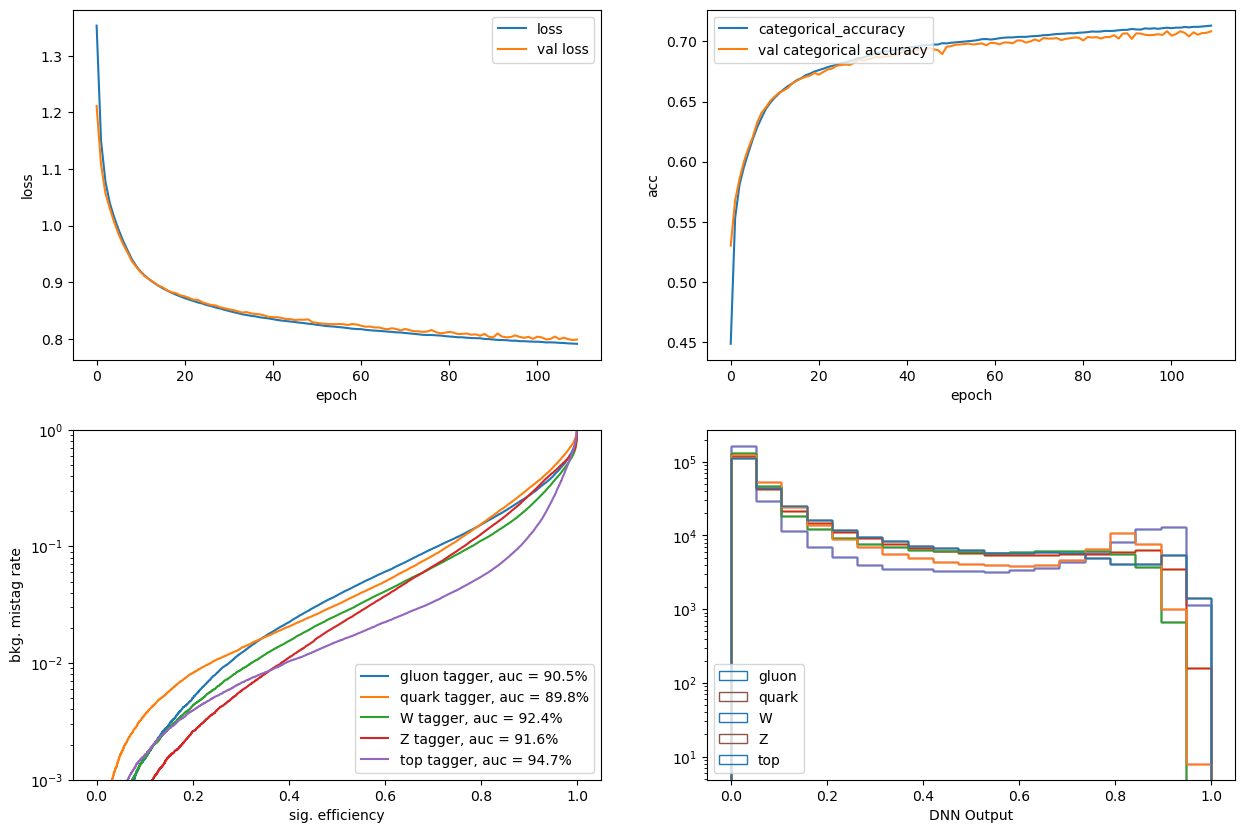

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))


ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')

# Display plots
fig = plt.gcf()
plt.show()


In [7]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)
  
'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''

# Get average ( between classes ) accuracy score 
#y_keras = model.predict(X_test)
# y_hls = hls_model.predict(np.ascontiguousarray(X_test))
# accuracy_keras  = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(y_keras,axis=1)))
# accuracy_hls4ml = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(y_hls,axis=1)))






Label =  gluon  with treshold =  0.3
TPR =  0.3000017104835537
FPR =  0.012115358912118377
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000085524177685
FPR =  0.03794133751837783
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000273677368592
FPR =  0.15328731508987353
 
Label =  quark  with treshold =  0.3
TPR =  0.3000495540138751
FPR =  0.01337774053425454
 
Label =  quark  with treshold =  0.5
TPR =  0.5000176978620983
FPR =  0.03158241269624106
 
Label =  quark  with treshold =  0.8
TPR =  0.8000318561517769
FPR =  0.15491928036392244
 
Label =  W  with treshold =  0.3
TPR =  0.3000154302467125
FPR =  0.00872139369939631
 
Label =  W  with treshold =  0.5
TPR =  0.500060006514993
FPR =  0.02561263050850379
 
Label =  W  with treshold =  0.8
TPR =  0.8000411473245667
FPR =  0.11171484834513278
 
Label =  Z  with treshold =  0.3
TPR =  0.3000154276016936
FPR =  0.005735511477486717
 
Label =  Z  with treshold =  0.5
TPR =  0.5000428544491489
FPR =  0.020860714547342746
 
Label 

"\n# Save confusion matrix ndarrays to .npz file\nwith open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:\n    vars = {}\n    vars[arch]=np.array(1) # save model name\n    for label in labels:\n        vars['tresholds_'+label+'_'+arch] = tresholds[label]\n        vars['TP_'+label+'_'+arch] = TP[label]\n        vars['FP_'+label+'_'+arch] = FP[label]\n        vars['TN_'+label+'_'+arch] = TN[label]\n        vars['FN_'+label+'_'+arch] = FN[label]\n        vars['TPR_'+arch] = tpr[label]\n        vars['FPR_'+arch] = fpr[label]\n        vars['NP_'+arch]= NP[label]\n        vars['NN_'+arch]= NN[label]\n        vars['auc_'+arch] = auc1[label] \n#        print(vars)\n    np.savez(file, **vars)\n"

In [8]:
# Save a sample of events for Thea test on HLS

print(X_test.shape)

# Keras average accuracy to compare with 
y_keras = model.predict(X_test)
accuracy_keras  = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)


njets=3000
print(X_test.shape)
np.save('x_test_{}const_QGraphConv.npy'.format(nconstit), X_test[0:njets,:])
np.save('y_test_{}const_QGraphConv.npy'.format(nconstit), Y_test[0:njets,:])
np.save('y_keras_{}const_QGraphConv.npy'.format(nconstit), y_keras[0:njets,:])



(290400, 32, 3)
accuracy_keras =  0.7121280991735537
(290400, 32, 3)
